In [1]:
#%matplotlib inline
# For interactive 3d plotting:
%matplotlib notebook

In [2]:
import numpy as np
import json

import pylab as plt
import mpl_toolkits.mplot3d as a3
import matplotlib.colors as colors

import shakemap.grind.fault as fault

In [3]:
# Path to deterministic UCERF3 file
jfile = "data/UCERF3_EventSet_All.json"
with open(jfile) as f:    
    ucerf = json.load(f)
nrup = len(ucerf['events'])

In [4]:
# Pick a big fault for viewing
i = 359 # Hayward
event_name = ucerf['events'][i]['name']
print(event_name)
magnitude = ucerf['events'][i]['magnitude']
print('Magnitude: %f' % magnitude)
dip = ucerf['events'][i]['dip']
rake = ucerf['events'][i]['rake']
print('rake: %f' %rake)
width = ucerf['events'][i]['width']

Hayward: RC+HN+HS+HE Shaw09Mod GEOL
Magnitude: 7.580000
rake: 178.200000


In [9]:
# Loop over sections and construct fault inputs
sections = np.array(ucerf['events'][i]['sections'])
nsections = len(sections)
secind = 0
new_seg_ind = []
rev = np.array([[]])
xp0 = np.array([[]])
xp1 = np.array([[]])
yp0 = np.array([[]])
yp1 = np.array([[]])
zp = np.array([[]])
dip_sec = np.array([[]])
strike_sec = np.array([[]])
width_sec = np.array([[]])
for j in range(0, nsections):
    trace_sec = np.array(sections[j]['resampledTrace'])
    top_sec_lon = trace_sec[:,0]
    top_sec_lat = trace_sec[:,1]
    top_sec_z = trace_sec[:,2]
    n_sec_trace = len(trace_sec) - 1
    dip_sec = np.append(dip_sec, np.repeat(sections[j]['dip'], n_sec_trace))
    dipDir_sec = np.repeat(sections[j]['dipDir'], n_sec_trace)
    strike_sec = np.append(strike_sec, dipDir_sec - 90)
    width_sec = np.append(width_sec, np.repeat(sections[j]['width'], n_sec_trace))
    rev_sec = sections[j]['reversed']
    rev = np.append(rev, np.repeat(rev_sec, n_sec_trace))
    xp0_sec = top_sec_lon[range(0, n_sec_trace)]
    xp1_sec = top_sec_lon[range(1, n_sec_trace + 1)]
    yp0_sec = top_sec_lat[range(0, n_sec_trace)]
    yp1_sec = top_sec_lat[range(1, n_sec_trace + 1)]
    zp_sec = top_sec_z[range(0, n_sec_trace)]
    if rev_sec == False:
        xp0 = np.append(xp0, xp0_sec)
        xp1 = np.append(xp1, xp1_sec)
        yp0 = np.append(yp0, yp0_sec)
        yp1 = np.append(yp1, yp1_sec)
        zp = np.append(zp, zp_sec)
    else:
        xp0 = np.append(xp0, xp0_sec[::-1])
        xp1 = np.append(xp1, xp1_sec[::-1])
        yp0 = np.append(yp0, yp0_sec[::-1])
        yp1 = np.append(yp1, yp1_sec[::-1])
        zp = np.append(zp, zp_sec[::-1])
    new_seg_ind.extend([secind]*n_sec_trace)
    secind = secind + 1

flt = fault.Fault.fromTrace(xp0, yp0, xp1, yp1, zp, 
                            width_sec, dip_sec, strike = strike_sec, 
                            reference = 'UCERF3 BSSC')

In [10]:
# Estimate xlim, ylim, zlim
buf = 0.1
latmin = np.min([yp1, yp0]) - buf
latmax = np.max([yp1, yp0]) + buf
lonmin = np.min([xp1, xp0]) - buf
lonmax = np.max([xp1, xp0]) + buf
dmax = 40

<IPython.core.display.Javascript object>


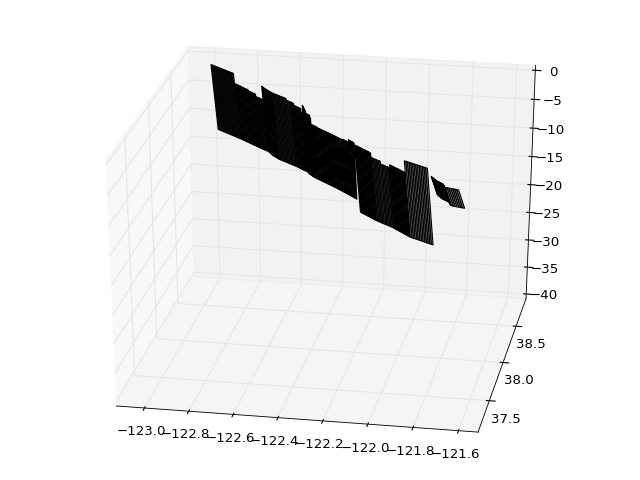

(-40, 0)

In [19]:
# 3D plot of fault
ax = a3.Axes3D(plt.figure())
quads = flt.getQuadrilaterals()
n_total = len(quads)
for i in range(0, n_total):
    vtx = np.column_stack([[s.longitude for s in quads[i]],
                           [s.latitude for s in quads[i]],
                           [-s.depth for s in quads[i]]
                          ])
    rup = a3.art3d.Poly3DCollection([vtx])
    rup.set_color(colors.rgb2hex([0.6, 0.6, 0.6]))
    rup.set_edgecolor('k')
    ax.add_collection3d(rup)

ax.set_xlim([lonmin, lonmax])
ax.set_ylim([latmin, latmax])
ax.set_zlim([-dmax, 0])